In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn import model_selection
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
from time import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
import joblib

from sklearn.tree import DecisionTreeRegressor
import catboost as cb
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# 1. Get the Data

In [2]:
# Import as variable
df = pd.read_csv('./dataset/movie_statistic_dataset.csv')
display(df)

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000,667830256,2265935552
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000,858373000,2794731755
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000,241071802,1045713802
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000,459005868,1395316979
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000,678815482,2048359754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,Super Size Me,2004-05-07,Documentary,100.0,Morgan Spurlock,"producer,writer,director",1970,alive,7.2,110078.0,6.017902,65000,11529368,22233808
4376,The Brothers McMullen,1995-08-09,"Comedy,Drama,Romance",98.0,Edward Burns,"actor,writer,producer",1968,alive,6.6,7986.0,4.231464,50000,10426506,10426506
4377,Gabriela,2001-03-16,"Drama,Romance",93.0,Vincent Jay Miller,"producer,director,writer",1973,alive,4.9,1593.0,2.526405,50000,2335352,2335352
4378,Tiny Furniture,2010-11-12,"Comedy,Drama,Romance",98.0,Lena Dunham,"writer,actress,producer",1986,alive,6.2,14595.0,4.242085,50000,391674,424149


In [3]:
# Extract two random rows for deployment testing
deployment_extract = df.sample(n=2, random_state=1)
display(deployment_extract)
for i in deployment_extract.index:
    df.drop(index=i, inplace=True)
display(df)

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $
3044,Rachel Getting Married,2008-10-03,"Drama,Romance",113.0,Jonathan Demme,"director,producer,writer",1944,2017,6.7,49863.0,5.200462,12000000,12796861,17475475
2359,Doubt,2008-12-12,"Drama,Mystery",104.0,John Patrick Shanley,"writer,director,soundtrack",1950,alive,7.5,131258.0,6.371246,20000000,33446470,53191101


,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000,667830256,2265935552
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000,858373000,2794731755
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000,241071802,1045713802
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000,459005868,1395316979
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000,678815482,2048359754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,Super Size Me,2004-05-07,Documentary,100.0,Morgan Spurlock,"producer,writer,director",1970,alive,7.2,110078.0,6.017902,65000,11529368,22233808
4376,The Brothers McMullen,1995-08-09,"Comedy,Drama,Romance",98.0,Edward Burns,"actor,writer,producer",1968,alive,6.6,7986.0,4.231464,50000,10426506,10426506
4377,Gabriela,2001-03-16,"Drama,Romance",93.0,Vincent Jay Miller,"producer,director,writer",1973,alive,4.9,1593.0,2.526405,50000,2335352,2335352
4378,Tiny Furniture,2010-11-12,"Comedy,Drama,Romance",98.0,Lena Dunham,"writer,actress,producer",1986,alive,6.2,14595.0,4.242085,50000,391674,424149


In [4]:
# Reset the index of the dataset, removing the old one
df = df.reset_index()
del df['index'] 
display(df)

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000,667830256,2265935552
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000,858373000,2794731755
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000,241071802,1045713802
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000,459005868,1395316979
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000,678815482,2048359754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,Super Size Me,2004-05-07,Documentary,100.0,Morgan Spurlock,"producer,writer,director",1970,alive,7.2,110078.0,6.017902,65000,11529368,22233808
4374,The Brothers McMullen,1995-08-09,"Comedy,Drama,Romance",98.0,Edward Burns,"actor,writer,producer",1968,alive,6.6,7986.0,4.231464,50000,10426506,10426506
4375,Gabriela,2001-03-16,"Drama,Romance",93.0,Vincent Jay Miller,"producer,director,writer",1973,alive,4.9,1593.0,2.526405,50000,2335352,2335352
4376,Tiny Furniture,2010-11-12,"Comedy,Drama,Romance",98.0,Lena Dunham,"writer,actress,producer",1986,alive,6.2,14595.0,4.242085,50000,391674,424149


In [5]:
# View Feature Headers
print(list(df.columns))

['movie_title', 'production_date', 'genres', 'runtime_minutes', 'director_name', 'director_professions', 'director_birthYear', 'director_deathYear', 'movie_averageRating', 'movie_numerOfVotes', 'approval_Index', 'Production budget $', 'Domestic gross $', 'Worldwide gross $']


In [6]:
# Modify Feature Headers
renamed_columns = {
    'director_birthYear' : 'director_birth', 
    'director_deathYear': 'director_death', 
    'movie_averageRating': 'rating', 
    'movie_numerOfVotes': 'votes', 
    'approval_Index': 'approval_index', 
    'Production budget $': 'budget', 
    'Domestic gross $': 'domestic_gross', 
    'Worldwide gross $': 'worldwide_gross' 
}
df.rename(renamed_columns, axis='columns', inplace=True)
display(df)

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000,667830256,2265935552
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000,858373000,2794731755
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000,241071802,1045713802
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000,459005868,1395316979
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000,678815482,2048359754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,Super Size Me,2004-05-07,Documentary,100.0,Morgan Spurlock,"producer,writer,director",1970,alive,7.2,110078.0,6.017902,65000,11529368,22233808
4374,The Brothers McMullen,1995-08-09,"Comedy,Drama,Romance",98.0,Edward Burns,"actor,writer,producer",1968,alive,6.6,7986.0,4.231464,50000,10426506,10426506
4375,Gabriela,2001-03-16,"Drama,Romance",93.0,Vincent Jay Miller,"producer,director,writer",1973,alive,4.9,1593.0,2.526405,50000,2335352,2335352
4376,Tiny Furniture,2010-11-12,"Comedy,Drama,Romance",98.0,Lena Dunham,"writer,actress,producer",1986,alive,6.2,14595.0,4.242085,50000,391674,424149


# 2. Visualise the Data

## 2.1 Data Discovery and Profiling

In [8]:
# Displays
display(df.head(5))
display(df.tail(5))
display(df.sample(5))

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000,667830256,2265935552
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000,858373000,2794731755
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000,241071802,1045713802
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000,459005868,1395316979
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000,678815482,2048359754


,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
4373,Super Size Me,2004-05-07,Documentary,100.0,Morgan Spurlock,"producer,writer,director",1970,alive,7.2,110078.0,6.017902,65000,11529368,22233808
4374,The Brothers McMullen,1995-08-09,"Comedy,Drama,Romance",98.0,Edward Burns,"actor,writer,producer",1968,alive,6.6,7986.0,4.231464,50000,10426506,10426506
4375,Gabriela,2001-03-16,"Drama,Romance",93.0,Vincent Jay Miller,"producer,director,writer",1973,alive,4.9,1593.0,2.526405,50000,2335352,2335352
4376,Tiny Furniture,2010-11-12,"Comedy,Drama,Romance",98.0,Lena Dunham,"writer,actress,producer",1986,alive,6.2,14595.0,4.242085,50000,391674,424149
4377,Counting,2015-07-31,Documentary,111.0,Jem Cohen,"director,cinematographer,editor",1962,alive,6.2,163.0,2.191765,50000,8374,8374


,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
228,Exodus: Gods and Kings,2014-12-05,"Action,Adventure,Drama",150.0,Ridley Scott,"producer,director,production_designer",1937,alive,6.0,170757.0,5.186766,140000000,65014513,268314513
937,After the Sunset,2004-11-12,"Action,Comedy,Crime",97.0,Brett Ratner,"producer,director,music_department",1969,alive,6.2,48307.0,4.788068,57000000,28328132,38329114
4145,Corpus Christi,2019-10-11,Drama,115.0,Jan Komasa,"director,writer,assistant_director",1981,alive,7.7,19566.0,5.466348,1300000,127240,10951283
1149,The Adventures of Ford Fairlane,1990-07-11,"Action,Adventure,Comedy",104.0,Renny Harlin,"producer,director,writer",1959,alive,6.4,18526.0,4.495482,49000000,20423389,20423389
221,Star Trek,2009-05-08,"Action,Adventure,Sci-Fi",127.0,J.J. Abrams,"producer,writer,music_department",1966,alive,7.9,606661.0,7.607847,140000000,257730019,386839614


In [9]:
# Dimensions
print(df.shape)

(4378, 14)


In [10]:
# Datatypes
print(df.dtypes)

movie_title              object
production_date          object
genres                   object
runtime_minutes         float64
director_name            object
director_professions     object
director_birth           object
director_death           object
rating                  float64
votes                   float64
approval_index          float64
budget                    int64
domestic_gross            int64
worldwide_gross           int64
dtype: object


In [11]:
# Structural Information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4378 entries, 0 to 4377
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           4378 non-null   object 
 1   production_date       4378 non-null   object 
 2   genres                4378 non-null   object 
 3   runtime_minutes       4378 non-null   float64
 4   director_name         4378 non-null   object 
 5   director_professions  4378 non-null   object 
 6   director_birth        4378 non-null   object 
 7   director_death        4378 non-null   object 
 8   rating                4378 non-null   float64
 9   votes                 4378 non-null   float64
 10  approval_index        4378 non-null   float64
 11  budget                4378 non-null   int64  
 12  domestic_gross        4378 non-null   int64  
 13  worldwide_gross       4378 non-null   int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 479.0+ KB
None


In [12]:
# NaN or Null Checks
print(df.isnull().sum())

movie_title             0
production_date         0
genres                  0
runtime_minutes         0
director_name           0
director_professions    0
director_birth          0
director_death          0
rating                  0
votes                   0
approval_index          0
budget                  0
domestic_gross          0
worldwide_gross         0
dtype: int64


In [13]:
# Infinite Value Checks
print(np.isinf(df.select_dtypes(include=[np.number])).sum()) 

runtime_minutes    0
rating             0
votes              0
approval_index     0
budget             0
domestic_gross     0
worldwide_gross    0
dtype: int64


In [14]:
# Checking for 'Missing Values' such as '-' or '/N'

# Checking production_date 
display(df[df['production_date'].str.fullmatch('-')])
display(df[df['production_date'].str.contains('N')].sum())

# Checking genres 
display(df[df['genres'].astype(str).str.fullmatch('-', na=False)].sum())

# Checking director_name
display(df[df['director_name'].str.fullmatch('-')]) # 326 rows, 7.4% of rows

# Checking rating
display(df[df['rating'].astype(str).str.fullmatch('-', na=False)].sum())
display(df[df['rating'].astype(str).str.contains('N')].sum())

# Checking votes
display(df[df['votes'].astype(str).str.fullmatch('-', na=False)].sum())
display(df[df['votes'].astype(str).str.contains('N')].sum())

# Checking approval_index
display(df[df['approval_index'].astype(str).str.fullmatch('-', na=False)].sum())
display(df[df['approval_index'].astype(str).str.contains('N')].sum())

# Checking budget
display(df[df['budget'].astype(str).str.fullmatch('-', na=False)].sum())
display(df[df['budget'].astype(str).str.contains('N')].sum())

# Checking domestic_gross
display(df[df['domestic_gross'].astype(str).str.fullmatch('-', na=False)].sum())
display(df[df['domestic_gross'].astype(str).str.contains('N')].sum())

# Checking worldwide_gross
display(df[df['worldwide_gross'].astype(str).str.fullmatch('-', na=False)].sum())
display(df[df['worldwide_gross'].astype(str).str.contains('N')].sum())

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross


movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000,858373000,2794731755
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000,678815482,2048359754
11,Tangled,2010-11-24,"Adventure,Animation,Comedy",100.0,-,-,-,-,7.7,459912.0,7.255014,260000000,200821936,583777242
13,Captain America: Civil War,2016-04-22,"Action,Sci-Fi",147.0,-,-,-,-,7.8,795308.0,7.665261,250000000,408084349,1151899586
23,Pirates of the Caribbean: Dead Men Tell No Tales,2017-05-23,"Action,Adventure,Fantasy",129.0,-,-,-,-,6.5,317158.0,5.926088,230000000,172558876,794861794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4328,Burn,2012-07-20,Documentary,86.0,-,-,-,-,7.3,748.0,3.422366,225000,1109276,1109276
4338,Short Cut to Nirvana: Kumbh Mela,2004-10-22,Documentary,85.0,-,-,-,-,7.0,150.0,2.448777,200000,381225,439651
4340,Baghead,2008-06-13,"Comedy,Drama,Horror",84.0,-,-,-,-,6.0,5093.0,3.636227,200000,140016,140016
4342,Malevolence,2004-09-10,"Action,Crime,Drama",127.0,-,-,-,-,4.4,108.0,1.383919,200000,126021,346106


movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

movie_title               0
production_date           0
genres                    0
runtime_minutes         0.0
director_name             0
director_professions      0
director_birth            0
director_death            0
rating                  0.0
votes                   0.0
approval_index          0.0
budget                    0
domestic_gross            0
worldwide_gross           0
dtype: object

In [15]:
# Nominal Aggregation
print(df.groupby('genres').size())
print(df.groupby('director_name').size())

genres
Action                         2
Action,Adventure               7
Action,Adventure,Animation    43
Action,Adventure,Biography     5
Action,Adventure,Comedy       97
                              ..
Romance,Sci-Fi,Thriller        1
Sci-Fi,Thriller                4
Thriller                       7
Western                        1
\N                             2
Length: 354, dtype: int64
director_name
-                       326
Aaron Woodley             1
Abderrahmane Sissako      1
Abel Ferrara              1
Adam Brooks               1
                       ... 
Zack Snyder               7
Zak Penn                  1
Zal Batmanglij            1
Zara Hayes                1
Émile Gaudreault          1
Length: 1834, dtype: int64


In [16]:
# Numeric Aggregation
print(df.groupby('votes').size()) # Displays the HUGE range of votes
print(df.groupby('budget').size()) # Likewise
print(df.groupby('domestic_gross').size()) # This one is interesting, which 3 movies had the SAME least dom_gross
print(df.groupby('worldwide_gross').size()) # Likewise

votes
5.0          2
6.0          2
7.0          3
8.0          2
9.0          1
            ..
2093927.0    1
2141276.0    1
2368570.0    1
2669915.0    1
2695887.0    1
Length: 4313, dtype: int64
budget
50000        4
65000        1
66000        1
68000        1
70000        1
            ..
300000000    3
365000000    1
379000000    1
400000000    1
460000000    1
Length: 403, dtype: int64
domestic_gross
264          3
388          1
423          1
528          1
884          1
            ..
700059566    1
718732821    1
785221649    1
814115070    1
858373000    1
Length: 4259, dtype: int64
worldwide_gross
423           1
528           1
884           1
1711          1
1822          1
             ..
2048359754    1
2222759773    1
2265935552    1
2794731755    1
2923706026    1
Length: 4274, dtype: int64


In [17]:
# Inconsistencies
print(df['rating'].unique())

[7.8 8.4 6.6 7.3 6.1 6.8 6.9 6.4 7.7 6.3 7.6 7.4 7.9 6.5 8.  7.1 5.8 5.2
 5.9 5.6 7.2 8.2 8.3 6.2 6.7 5.5 5.4 7.  5.7 9.  7.5 5.3 4.9 6.  8.1 8.6
 8.8 4.  5.1 4.5 4.8 3.7 3.9 8.5 4.2 2.  3.4 2.8 2.2 3.8 4.3 4.4 4.6 5.
 3.3 4.1 4.7 3.1 3.6 8.7 2.6 3.5 2.5 2.1 9.3 2.4 1.9 1.5 2.9 3.2 1.6 8.9
 9.2 3. ]


In [18]:
# Checking Duplicates
print(df[df.duplicated()])

Empty DataFrame
Columns: [movie_title, production_date, genres, runtime_minutes, director_name, director_professions, director_birth, director_death, rating, votes, approval_index, budget, domestic_gross, worldwide_gross]
Index: []


In [19]:
# Distinct Values
print(df.nunique())

movie_title             4239
production_date         2458
genres                   354
runtime_minutes          138
director_name           1834
director_professions     317
director_birth           103
director_death            63
rating                    74
votes                   4313
approval_index          4378
budget                   403
domestic_gross          4259
worldwide_gross         4274
dtype: int64


In [20]:
# Statistical Summary
print(df.describe())

       runtime_minutes       rating         votes  approval_index  \
count      4378.000000  4378.000000  4.378000e+03     4378.000000   
mean        109.786661     6.407127  1.369815e+05        5.032289   
std          20.379990     1.024092  2.151208e+05        1.385056   
min          63.000000     1.500000  5.000000e+00        0.395487   
25%          96.000000     5.800000  2.140150e+04        4.178116   
50%         106.000000     6.500000  6.497950e+04        5.038326   
75%         120.000000     7.100000  1.599495e+05        5.944010   
max         271.000000     9.300000  2.695887e+06       10.000000   

             budget  domestic_gross  worldwide_gross  
count  4.378000e+03    4.378000e+03     4.378000e+03  
mean   3.870414e+07    5.257730e+07     1.149555e+08  
std    4.574552e+07    7.510232e+07     2.007277e+08  
min    5.000000e+04    2.640000e+02     4.230000e+02  
25%    1.000000e+07    8.865210e+06     1.297780e+07  
50%    2.300000e+07    2.832282e+07     4.448247

In [21]:
# Modified View for Statistical Summary
pd.options.display.float_format = '{:.2f}'.format
print(df.describe())

       runtime_minutes  rating      votes  approval_index       budget  \
count          4378.00 4378.00    4378.00         4378.00      4378.00   
mean            109.79    6.41  136981.47            5.03  38704136.41   
std              20.38    1.02  215120.77            1.39  45745515.27   
min              63.00    1.50       5.00            0.40     50000.00   
25%              96.00    5.80   21401.50            4.18  10000000.00   
50%             106.00    6.50   64979.50            5.04  23000000.00   
75%             120.00    7.10  159949.50            5.94  50000000.00   
max             271.00    9.30 2695887.00           10.00 460000000.00   

       domestic_gross  worldwide_gross  
count         4378.00          4378.00  
mean      52577296.11     114955509.54  
std       75102317.06     200727676.07  
min            264.00           423.00  
25%        8865210.50      12977800.75  
50%       28322822.50      44482468.00  
75%       64145266.75     128073123.25  
max  

In [22]:
# Correlation Matrix
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
display(numeric_columns.corr())

,runtime_minutes,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
runtime_minutes,1.00,0.40,0.31,0.40,0.27,0.23,0.24
rating,0.40,1.00,0.48,0.83,0.07,0.25,0.22
votes,0.31,0.48,1.00,0.70,0.41,0.60,0.58
approval_index,0.40,0.83,0.70,1.00,0.28,0.45,0.41
budget,0.27,0.07,0.41,0.28,1.00,0.66,0.73
domestic_gross,0.23,0.25,0.60,0.45,0.66,1.00,0.94
worldwide_gross,0.24,0.22,0.58,0.41,0.73,0.94,1.00


In [23]:
# Interesting Observations

# 1 - Checking the odd 3 movies that happen to have the exact same lowest revenue value
df_sorted = df.sort_values(by='domestic_gross', ascending=True)
display(df_sorted.head(3))

# 2 - Reviewing all the movies with the same title
df_duplicates = df[df.duplicated(subset=['movie_title'], keep=False)].sort_values(by='movie_title')
display(df_duplicates)

# 3 - Movie with the longest runtime
df_sorted = df.sort_values(by='runtime_minutes', ascending=False)
top = pd.DataFrame(df_sorted.head(1))
display(top)

# 4 - Movie with the highest budget
display(df[df['budget'] == df['budget'].max()])

# 5 - Movie with the highest worldwide gross
display(df[df['worldwide_gross'] == df['worldwide_gross'].max()])

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
4137,Playback,2012-03-16,Documentary,66.00,-,-,-,-,6.00,16.00,1.09,1500000,264,54945
4136,Playback,2012-03-16,Drama,113.00,Shô Miyake,"director,writer,actor",1984,alive,4.80,49.00,1.24,1500000,264,54945
4135,Playback,2012-03-16,"Horror,Thriller",98.00,Michael A. Nickles,"actor,writer,director",1968,alive,4.20,5004.00,2.50,1500000,264,54945


,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
4333,"20,000 Leagues Under the Sea",1916-12-24,"Action,Adventure,Sci-Fi",85.00,Stuart Paton,"director,writer,actor",1883,1944,6.10,1849.00,3.24,200000,8000000,8000000
3667,"20,000 Leagues Under the Sea",1954-12-23,"Adventure,Drama,Family",127.00,Richard Fleischer,"director,producer,writer",1916,2006,7.20,34770.00,5.41,5000000,28200000,28200000
3266,A Better Life,2011-06-24,"Drama,Romance",98.00,Chris Weitz,"producer,writer,director",1969,alive,7.20,16133.00,5.00,10000000,1759252,1884251
3267,A Better Life,2011-06-24,Drama,110.00,Cédric Kahn,"actor,writer,director",1966,alive,6.60,1744.00,3.49,10000000,1759252,1884251
4096,A Nightmare on Elm Street,1984-11-09,Horror,91.00,Wes Craven,"writer,producer,director",1939,2015,7.40,244163.00,6.62,1800000,25504513,25542906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347,Weekend,2011-09-23,"Drama,Romance",97.00,Andrew Haigh,"producer,director,writer",1973,alive,7.60,30966.00,5.65,190000,484592,1577585
4348,Weekend,2011-09-23,"Action,Comedy,Crime",121.00,Cezary Pazura,"actor,producer,director",1962,alive,3.90,705.00,1.75,190000,484592,1577585
4349,Weekend,2011-09-23,"Comedy,Drama",80.00,Randal Kamradt,"visual_effects,producer,director",\N,alive,5.80,7.00,0.70,190000,484592,1577585
395,West Side Story,2021-12-08,"Crime,Drama,Musical",156.00,Steven Spielberg,"producer,writer,director",1946,alive,7.20,85354.00,5.88,100000000,38530322,74826329


,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
2114,Gettysburg,1993-10-08,"Drama,History,War",271.00,Ron Maxwell,"director,producer,writer",1949,alive,7.60,29736.00,5.63,25000000,10731997,10731997


,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.00,James Cameron,"writer,producer,director",1954,alive,7.80,277543.00,7.06,460000000,667830256,2265935552


,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
20,Avatar,2009-12-17,"Action,Adventure,Fantasy",162.00,James Cameron,"writer,producer,director",1954,alive,7.90,1316701.00,8.06,237000000,785221649,2923706026


In [24]:
# Display Genre Outlier
news_row = df[df['genres'].str.contains('News', na=False)]
display(news_row)

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
4176,An Inconvenient Truth,2006-05-24,"Documentary,News",96.00,Davis Guggenheim,"producer,director,writer",1963,alive,7.40,83892.00,6.04,1000000,24146161,53365925


## 2.2 Exploratory Data Analysis

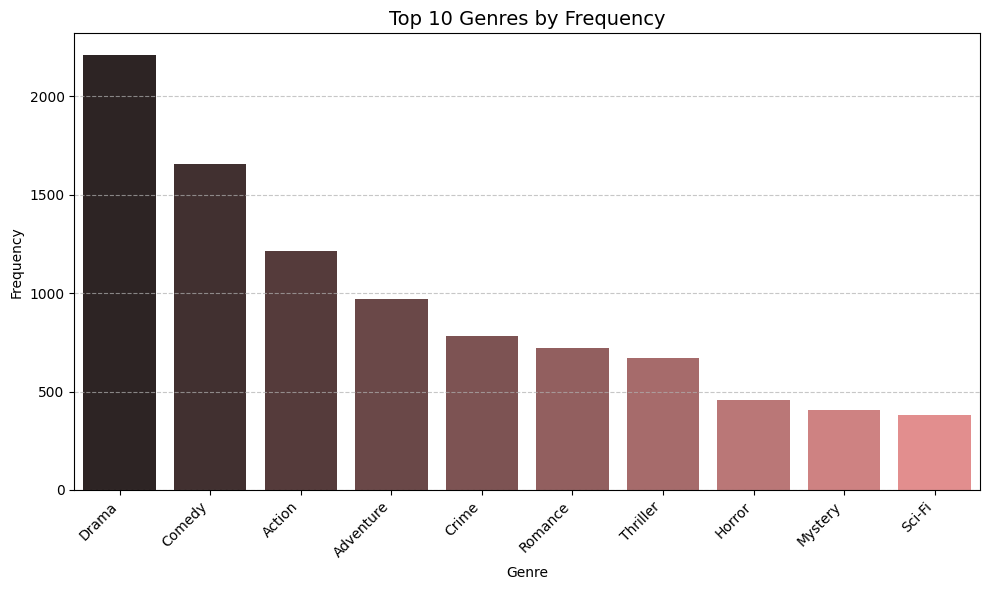

In [25]:
# Individual Frequency - Top 10 Genres
genres_separate = df['genres'].str.split(',').explode()
top_10_genres = genres_separate.value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_genres.index,  
    y=top_10_genres.values,  
    palette='dark:lightcoral',
    hue=top_10_genres.index
)
plt.title('Top 10 Genres by Frequency', fontsize=14)
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

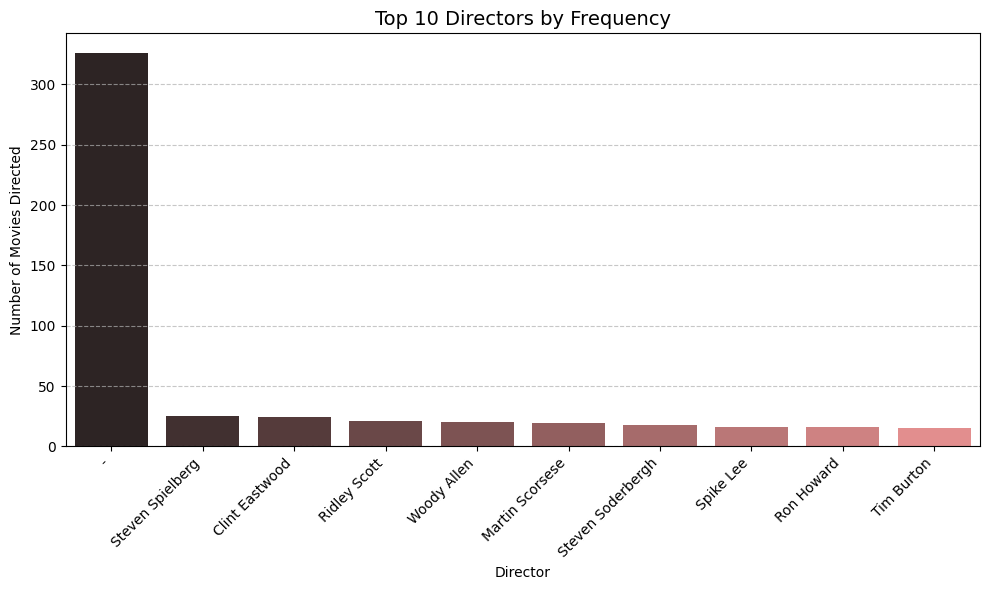

In [26]:
# Individual Frequency - Top 10 Directors
top_10_directors_by_frequency = df['director_name'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_directors_by_frequency.index,  
    y=top_10_directors_by_frequency.values,  
    palette='dark:lightcoral',
    hue=top_10_directors_by_frequency.index
)
plt.title('Top 10 Directors by Frequency', fontsize=14)
plt.xlabel('Director')
plt.ylabel('Number of Movies Directed')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

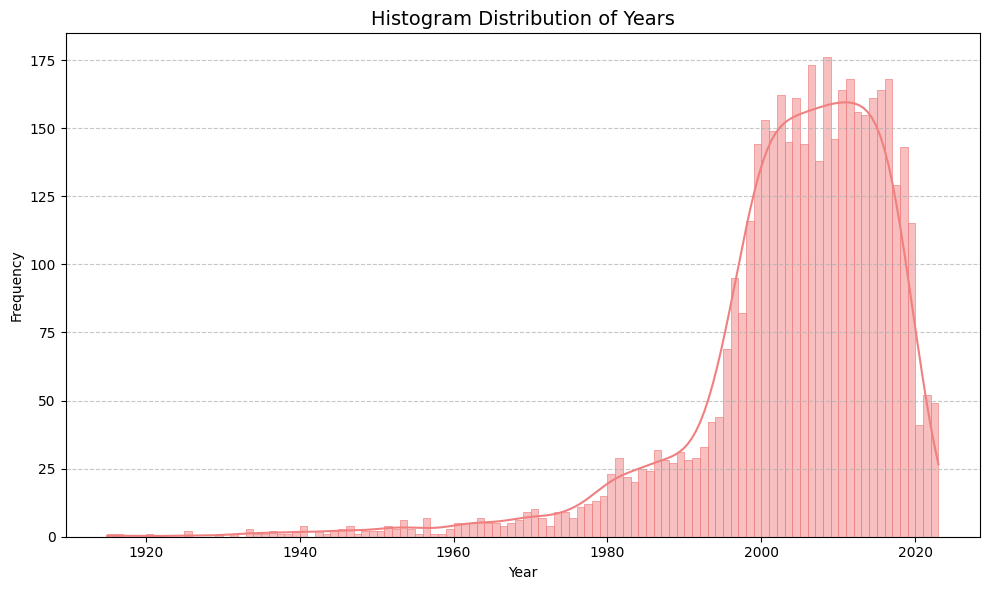

In [27]:
# Individual Frequency - Years
df['date'] = pd.to_datetime(df['production_date'], errors='coerce')
df['year'] = df['date'].dt.year  
plt.figure(figsize=(10, 6))
sns.histplot(
    df['year'], 
    bins=range(df['year'].min(), df['year'].max() + 1), 
    color='lightcoral', 
    edgecolor='lightcoral', 
    kde=True
)
plt.title('Histogram Distribution of Years', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Undo Dataframe Manipulation
del df['date']
del df['year']

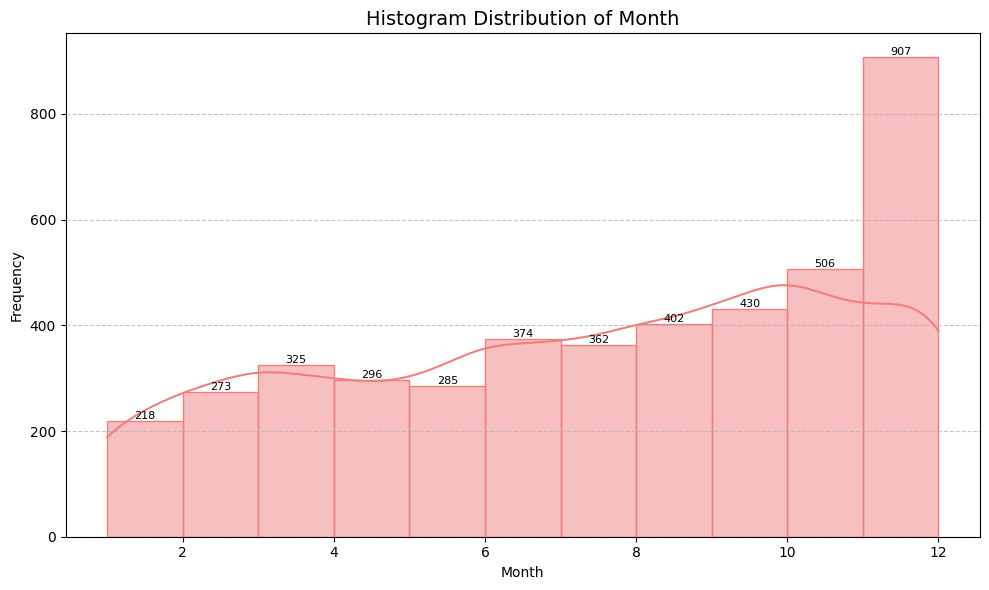

In [28]:
# Individual Frequency - Months
df['date'] = pd.to_datetime(df['production_date'], errors='coerce')  
df['month'] = df['date'].dt.month  
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    df['month'], 
    bins=range(df['month'].min(), df['month'].max() + 1), 
    color='lightcoral', 
    edgecolor='lightcoral', 
    kde=True
)
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  
        plt.text(
            patch.get_x() + patch.get_width() / 2,  
            height,  # Bar height
            f'{int(height)}',  
            ha='center', 
            va='bottom', 
            fontsize=8
        )
plt.title('Histogram Distribution of Month', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Undo Dataframe Manipulation
del df['date']
del df['month']

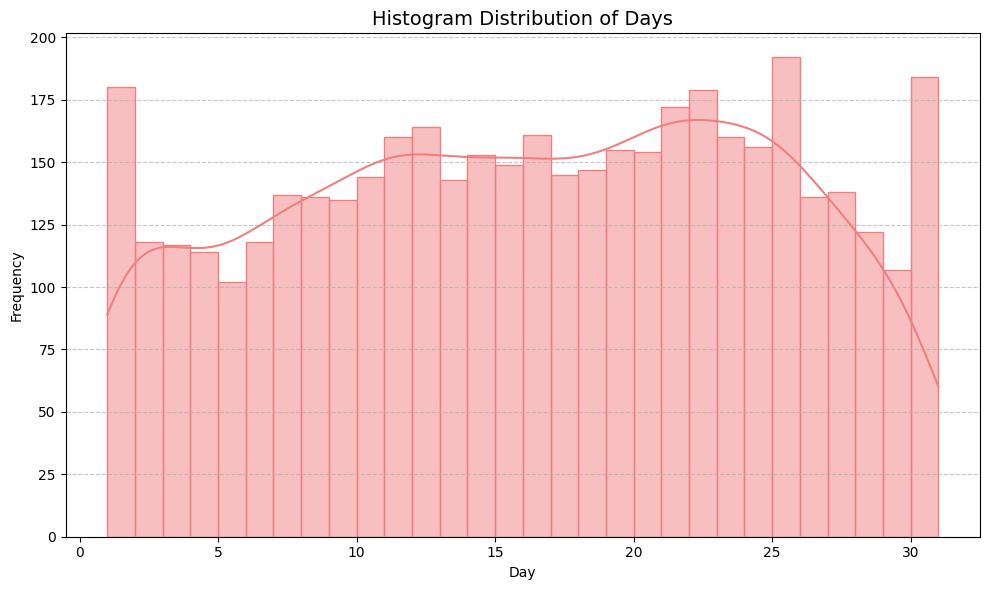

In [29]:
# Individual Frequency - Days
df['date'] = pd.to_datetime(df['production_date'], errors='coerce')  
df['day'] = df['date'].dt.day  
plt.figure(figsize=(10, 6))
sns.histplot(
    df['day'], 
    bins=range(df['day'].min(), df['day'].max() + 1), 
    color='lightcoral', 
    edgecolor='lightcoral', 
    kde=True
)
plt.title('Histogram Distribution of Days', fontsize=14)
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Undo Dataframe Manipulation
del df['date']
del df['day']

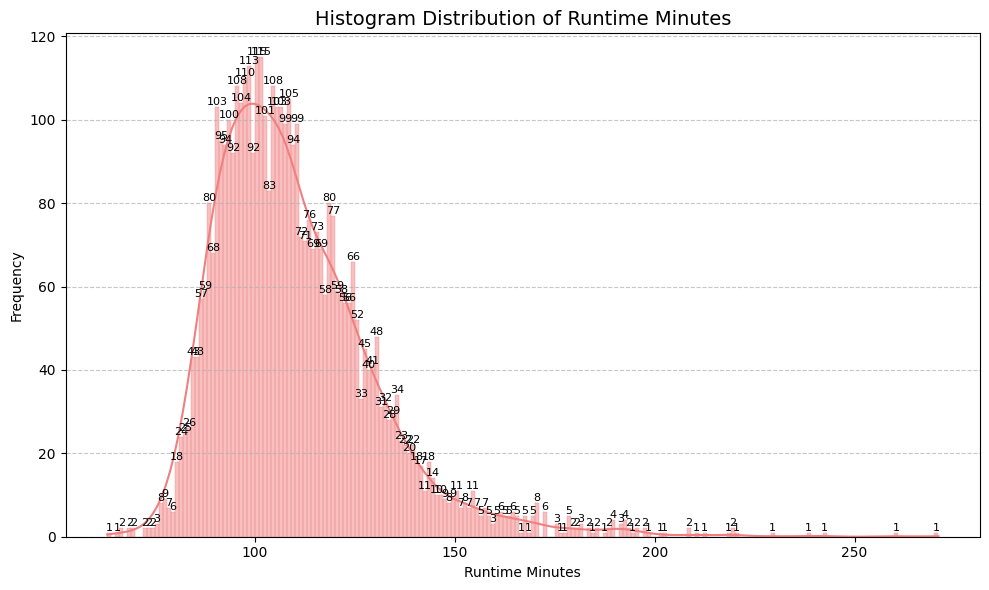

In [30]:
# Individual Frequency - Runtime Minutes
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    df['runtime_minutes'], 
    bins=range(int(df['runtime_minutes'].min()), int(df['runtime_minutes'].max()) + 1), 
    color='lightcoral', 
    edgecolor='lightcoral', 
    kde=True
)
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  
        plt.text(
            patch.get_x() + patch.get_width() / 2,  
            height,  # Bar height
            f'{int(height)}',  
            ha='center', 
            va='bottom', 
            fontsize=8
        )
plt.title('Histogram Distribution of Runtime Minutes', fontsize=14)
plt.xlabel('Runtime Minutes')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

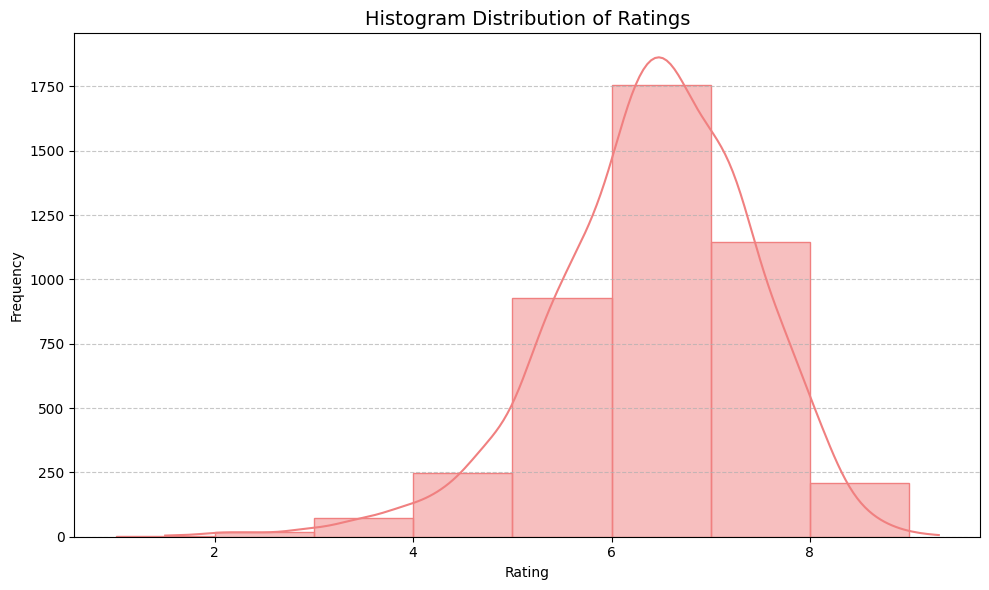

In [31]:
# Individual Frequency - Ratings
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    df['rating'], 
    bins=range(int(df['rating'].min()), int(df['rating'].max()) + 1), 
    color='lightcoral', 
    edgecolor='lightcoral', 
    kde=True
)
plt.title('Histogram Distribution of Ratings', fontsize=14)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

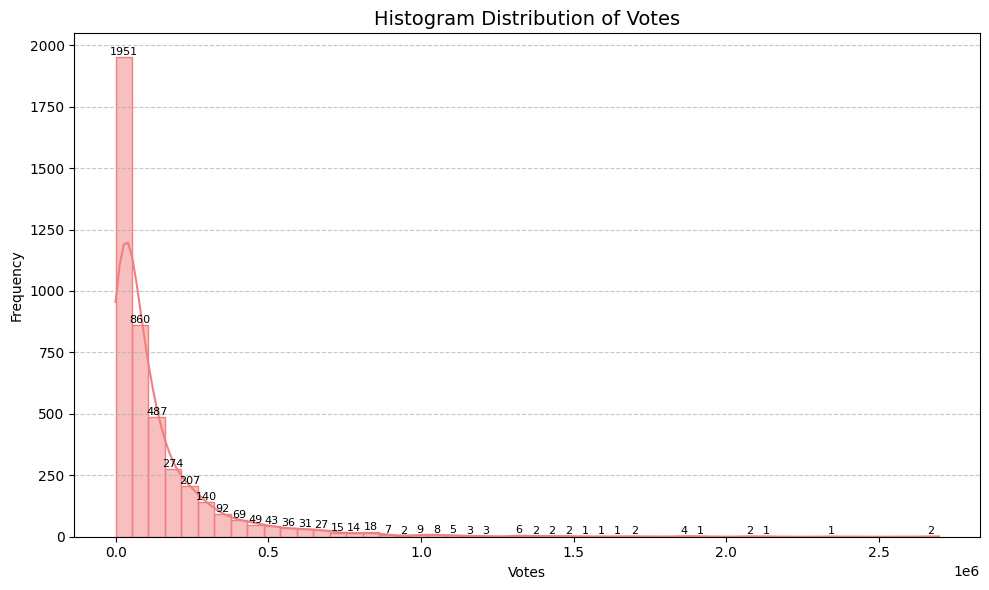

In [32]:
# Individual Frequency - Votes
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    df['votes'], 
    bins=50, 
    color='lightcoral', 
    edgecolor='lightcoral', 
    kde=True
)
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  
        plt.text(
            patch.get_x() + patch.get_width() / 2,  
            height,  # Bar height
            f'{int(height)}',  
            ha='center', 
            va='bottom', 
            fontsize=8
        )
plt.title('Histogram Distribution of Votes', fontsize=14)
plt.xlabel('Votes')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

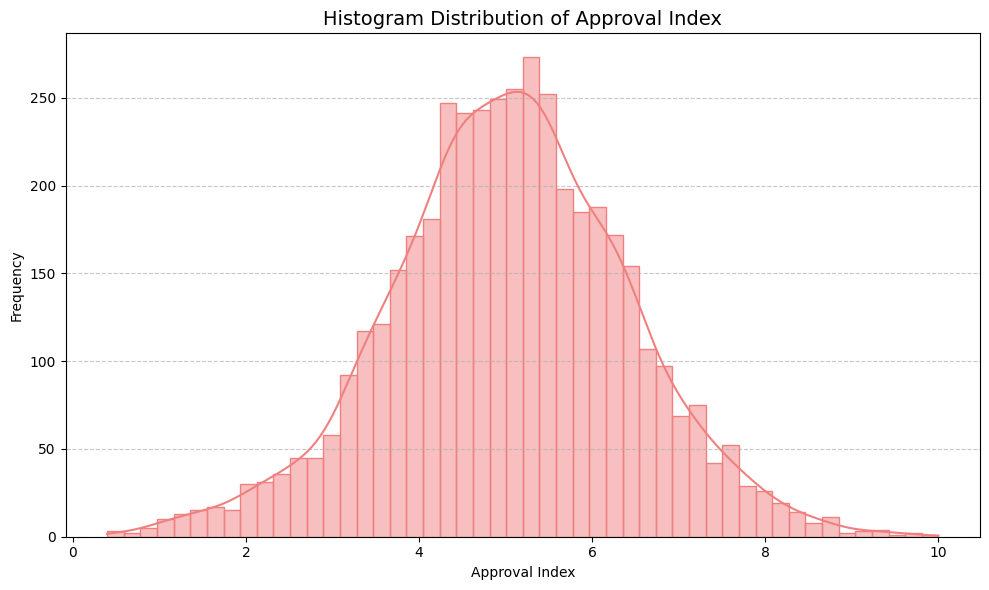

In [33]:
# Individual Frequency - Approval Index
plt.figure(figsize=(10, 6))
sns.histplot(
    df['approval_index'], 
    bins=50, 
    color='lightcoral', 
    edgecolor='lightcoral', 
    kde=True
)
plt.title('Histogram Distribution of Approval Index', fontsize=14)
plt.xlabel('Approval Index')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

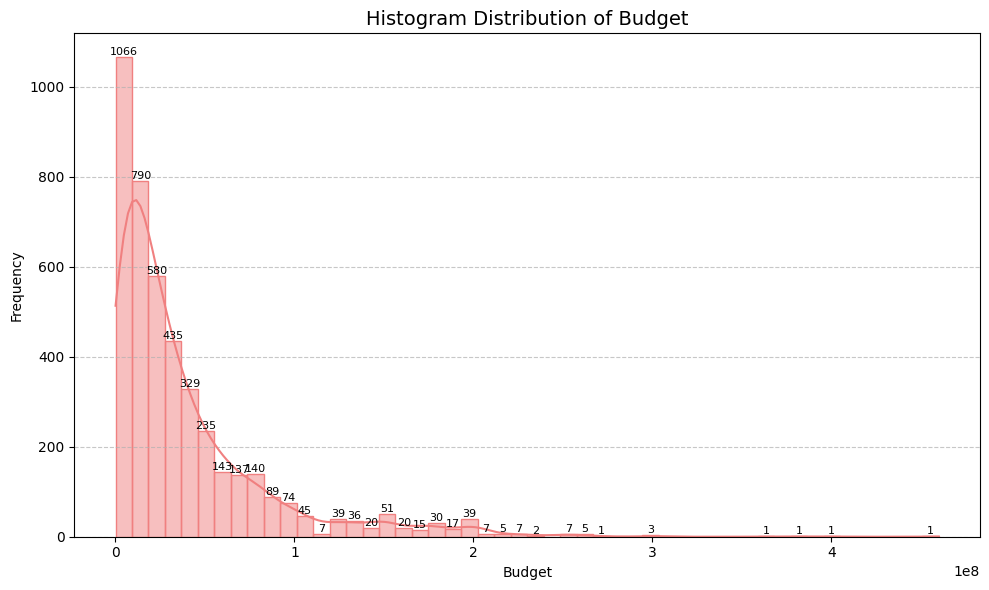

In [34]:
# Individual Frequency - Budget
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    df['budget'], 
    bins=50, 
    color='lightcoral', 
    edgecolor='lightcoral', 
    kde=True
)
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  
        plt.text(
            patch.get_x() + patch.get_width() / 2,  
            height,  # Bar height
            f'{int(height)}',  
            ha='center', 
            va='bottom', 
            fontsize=8
        )
plt.title('Histogram Distribution of Budget', fontsize=14)
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

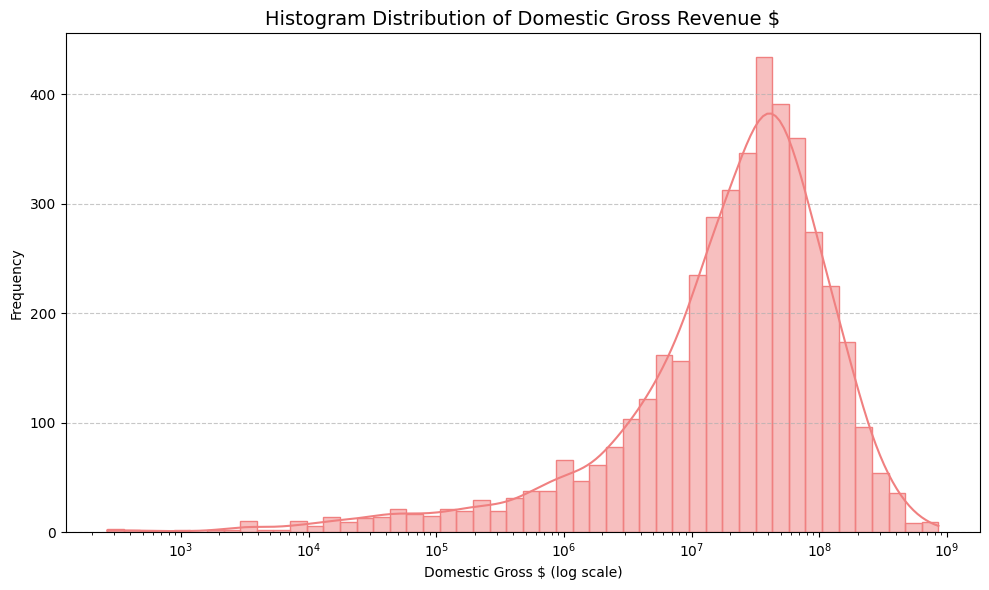

In [35]:
# Individual Frequency - Domestic Gross $
plt.figure(figsize=(10, 6))
sns.histplot(
    df['domestic_gross'], 
    bins=50, 
    color='lightcoral', 
    edgecolor='lightcoral', 
    log_scale=True,
    kde=True
)
plt.title('Histogram Distribution of Domestic Gross Revenue $', fontsize=14)
plt.xlabel('Domestic Gross $ (log scale)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

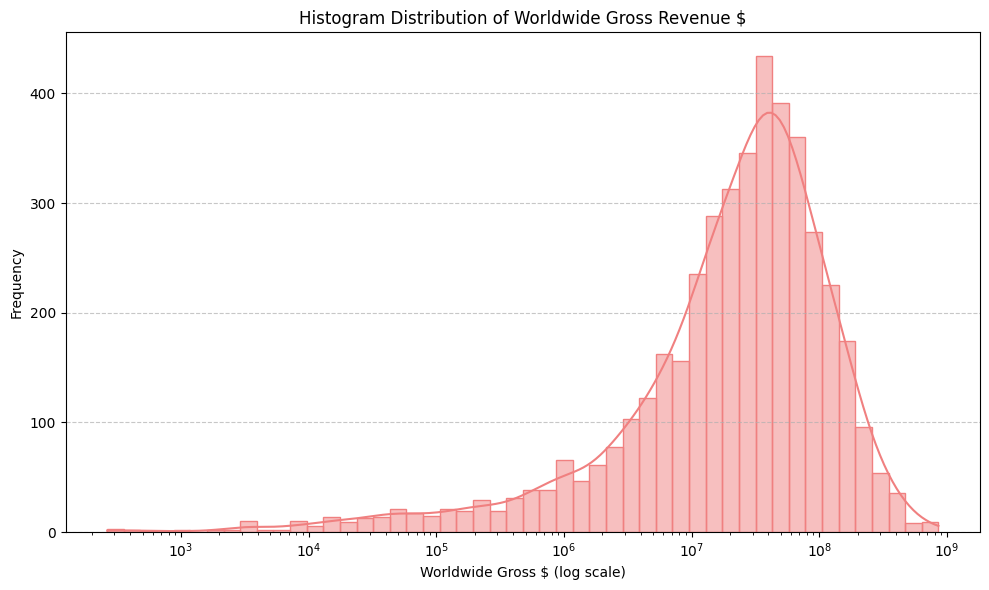

In [36]:
# Individual Frequency - Worldwide Gross $ 
plt.figure(figsize=(10, 6))
sns.histplot(
    df['domestic_gross'], 
    bins=50, 
    color='lightcoral', 
    edgecolor='lightcoral', 
    log_scale=True, 
    kde=True
)
plt.title('Histogram Distribution of Worldwide Gross Revenue $')
plt.xlabel('Worldwide Gross $ (log scale)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

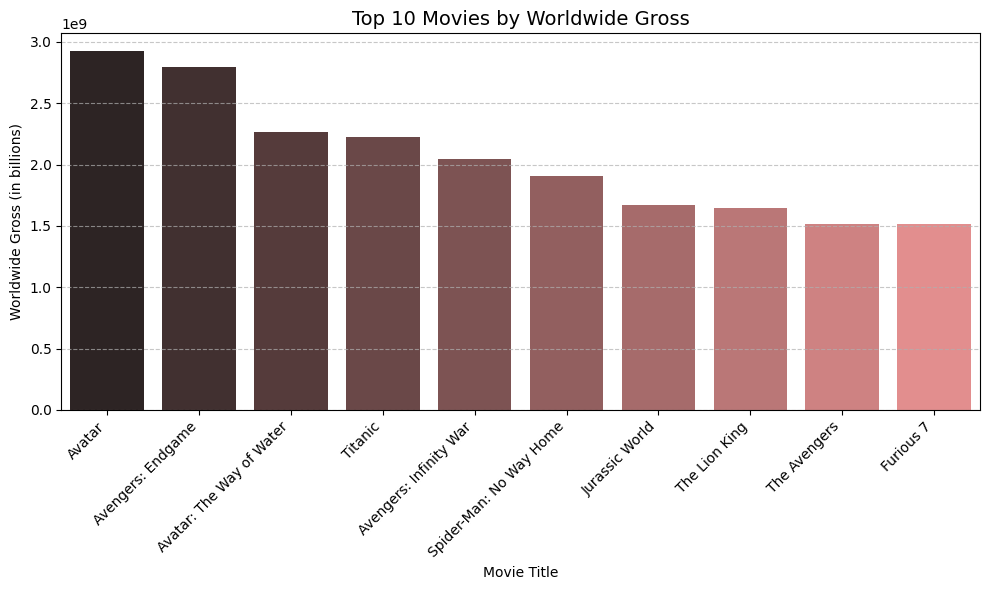

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
502,102 Dalmatians,2000-11-22,"Adventure,Comedy,Family",100.00,Kevin Lima,"animation_department,director,producer",1962,alive,4.80,38163.00,3.59,85000000,66941559,66941559
512,Meet Joe Black,1998-11-13,"Drama,Fantasy,Romance",178.00,Martin Brest,"director,actor,producer",1951,alive,7.20,246562.00,6.45,85000000,44650003,44650003
574,Mighty Joe Young,1998-12-25,"Action,Adventure,Family",114.00,Ron Underwood,"director,writer,producer",1953,alive,5.70,29688.00,4.19,80000000,50632037,50632037
629,Inspector Gadget,1999-07-23,"Action,Adventure,Comedy",78.00,David Kellogg,"director,producer,writer",1952,alive,4.10,49017.00,3.13,75000000,97387965,97387965
646,Anna and the King,1999-12-17,"Drama,History,Romance",148.00,Andy Tennant,"producer,director,writer",1955,alive,6.70,37805.00,5.06,75000000,39251128,39251128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4369,The Last House on the Left,1972-08-30,"Crime,Horror,Thriller",84.00,Wes Craven,"writer,producer,director",1939,2015,5.90,38123.00,4.45,87000,3100000,3100000
4370,Happy Christmas,2014-07-25,"Comedy,Drama",82.00,Joe Swanberg,"writer,actor,producer",1981,alive,5.40,8561.00,3.47,70000,30312,30312
4374,The Brothers McMullen,1995-08-09,"Comedy,Drama,Romance",98.00,Edward Burns,"actor,writer,producer",1968,alive,6.60,7986.00,4.23,50000,10426506,10426506
4375,Gabriela,2001-03-16,"Drama,Romance",93.00,Vincent Jay Miller,"producer,director,writer",1973,alive,4.90,1593.00,2.53,50000,2335352,2335352


In [37]:
# Comparison Against Worldwide Gross - Top 10 Movies
top_10_movies = df.nlargest(10, 'worldwide_gross')
plt.figure(figsize=(10, 6))
sns.barplot(
    x='movie_title',  
    y='worldwide_gross',  
    data=top_10_movies,  
    palette='dark:lightcoral',
    hue='movie_title'
)
plt.title('Top 10 Movies by Worldwide Gross', fontsize=14)
plt.xlabel('Movie Title')
plt.ylabel('Worldwide Gross (in billions)') # not sure if its actually in billiond
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 18% have the exact same values !!
same_gross_df = df[df['domestic_gross'] == df['worldwide_gross']]
display(same_gross_df)

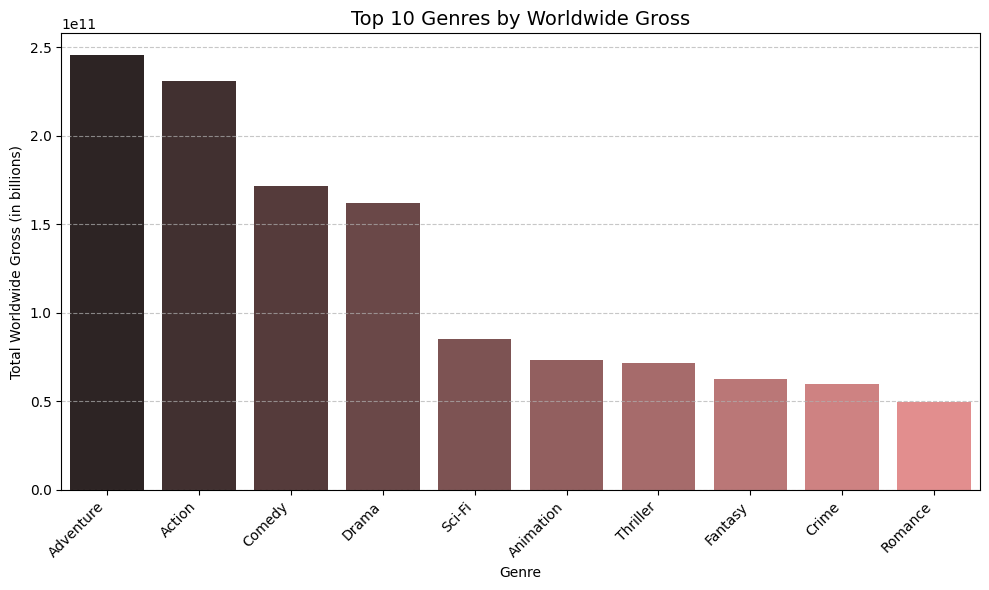

In [38]:
# Comparison Against Worldwide Gross - Top 10 Genres
genres_exploded = df['genres'].str.split(',').explode()
genres_exploded_with_gross = df.loc[genres_exploded.index, ['worldwide_gross']].copy()
top_10_genres_by_gross = genres_exploded_with_gross.groupby(genres_exploded).sum().nlargest(10, 'worldwide_gross')
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_genres_by_gross.index,  
    y=top_10_genres_by_gross['worldwide_gross'],  
    palette='dark:lightcoral',
    hue=top_10_genres_by_gross.index
)
plt.title('Top 10 Genres by Worldwide Gross', fontsize=14)
plt.xlabel('Genre')
plt.ylabel('Total Worldwide Gross (in billions)')  # assuming it's in billions
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

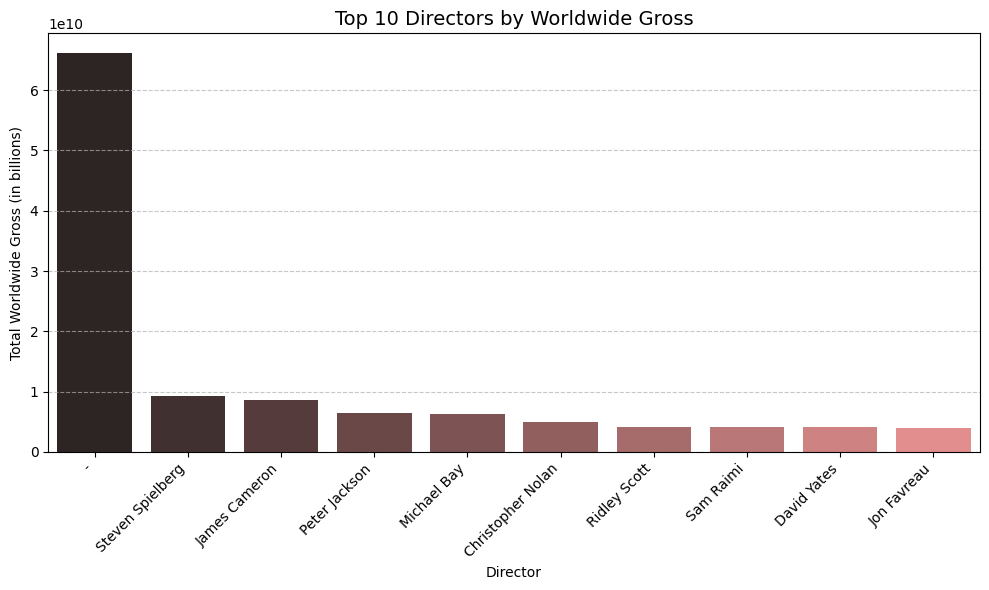

In [39]:
# Comparison Against Worldwide Gross - Top 10 Directors
top_10_directors = df.groupby('director_name')['worldwide_gross'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_directors.index,  
    y=top_10_directors.values,  
    palette='dark:lightcoral',
    hue=top_10_directors.index
)
plt.title('Top 10 Directors by Worldwide Gross', fontsize=14)
plt.xlabel('Director')
plt.ylabel('Total Worldwide Gross (in billions)')  
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

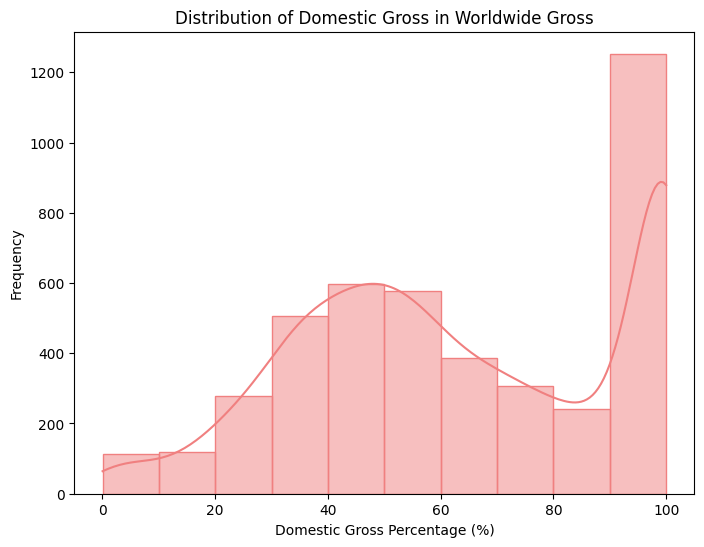

In [40]:
# Relationships - Distribution of Domestic Gross in Worldwide Gross
df['percentage'] = (df['domestic_gross'] / df['worldwide_gross']) * 100
percentage_df = df[['percentage']]
del df['percentage']
plt.figure(figsize=(8, 6))
sns.histplot(percentage_df['percentage'], bins=10, kde=True, color='lightcoral', edgecolor='lightcoral')
plt.xlabel('Domestic Gross Percentage (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Domestic Gross in Worldwide Gross')
plt.show()

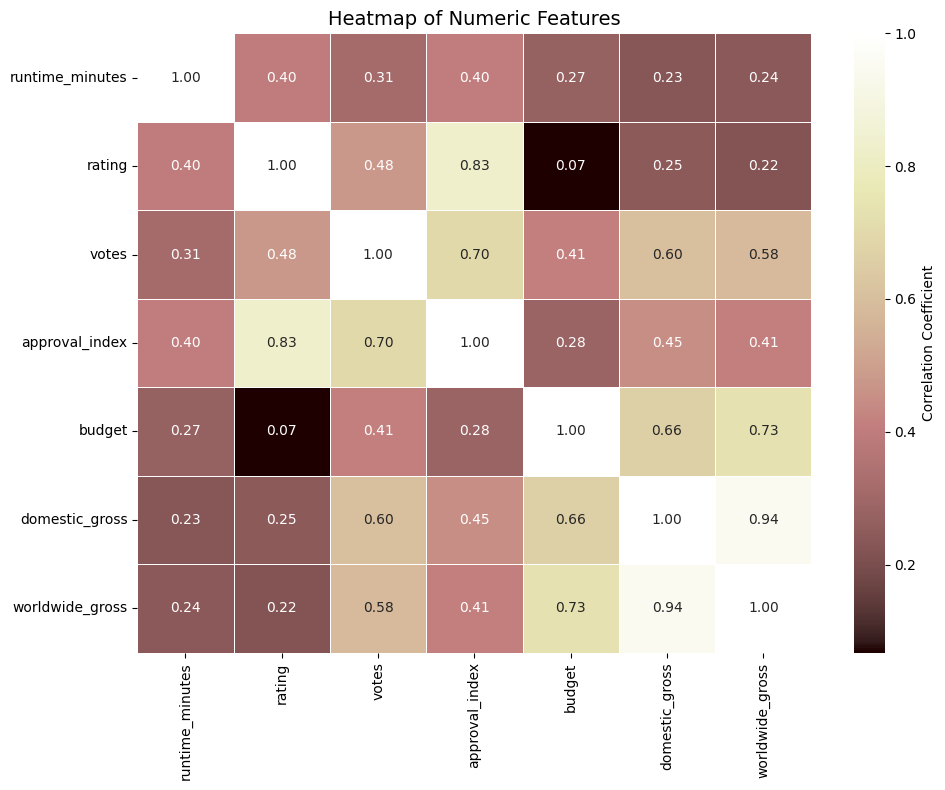

In [41]:
# Relationships - Heatmap
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="pink",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Heatmap of Numeric Features', fontsize=14)
plt.tight_layout()
plt.show()

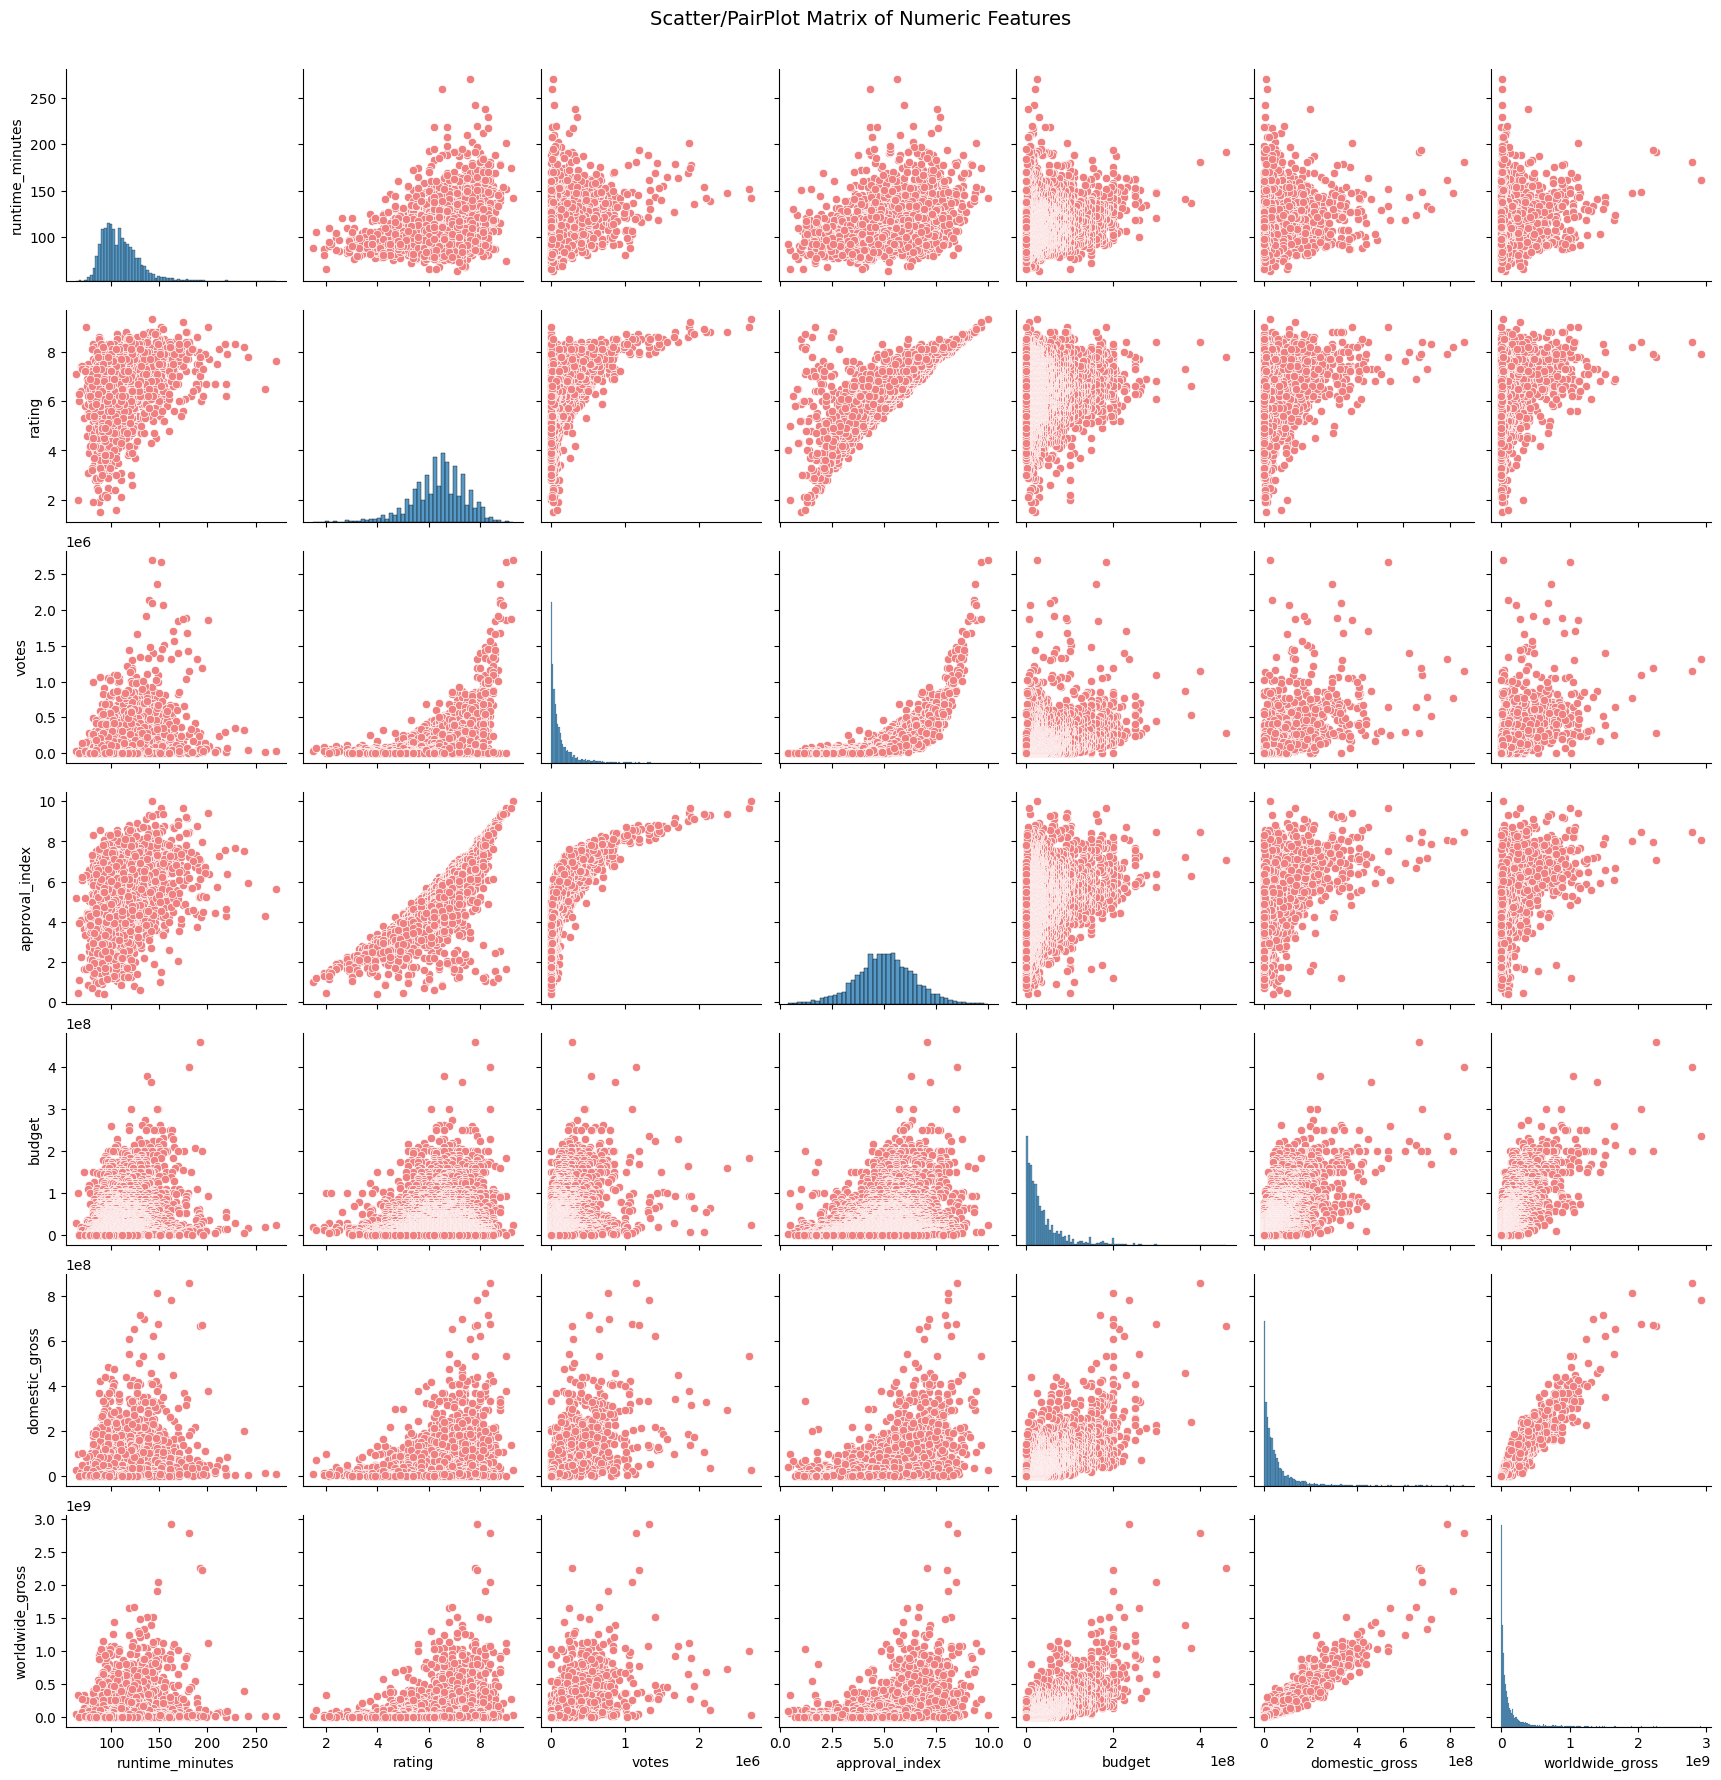

In [42]:
# Relationships - Scatter / PairPlot Matrix
numeric_features = [
    'runtime_minutes', 
    'rating', 
    'votes', 
    'approval_index', 
    'budget', 
    'domestic_gross', 
    'worldwide_gross'
]
sns.pairplot(df[numeric_features], plot_kws={'color': 'lightcoral'})
plt.suptitle('Scatter/PairPlot Matrix of Numeric Features', y=1.02, fontsize=14)
plt.show()

In [43]:
# Ensure Dataframe has no unintended manipulation
display(df)

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.00,James Cameron,"writer,producer,director",1954,alive,7.80,277543.00,7.06,460000000,667830256,2265935552
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.00,-,-,-,-,8.40,1143642.00,8.49,400000000,858373000,2794731755
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.00,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.60,533763.00,6.27,379000000,241071802,1045713802
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.00,Joss Whedon,"writer,producer,director",1964,alive,7.30,870573.00,7.21,365000000,459005868,1395316979
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.00,-,-,-,-,8.40,1091968.00,8.46,300000000,678815482,2048359754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,Super Size Me,2004-05-07,Documentary,100.00,Morgan Spurlock,"producer,writer,director",1970,alive,7.20,110078.00,6.02,65000,11529368,22233808
4374,The Brothers McMullen,1995-08-09,"Comedy,Drama,Romance",98.00,Edward Burns,"actor,writer,producer",1968,alive,6.60,7986.00,4.23,50000,10426506,10426506
4375,Gabriela,2001-03-16,"Drama,Romance",93.00,Vincent Jay Miller,"producer,director,writer",1973,alive,4.90,1593.00,2.53,50000,2335352,2335352
4376,Tiny Furniture,2010-11-12,"Comedy,Drama,Romance",98.00,Lena Dunham,"writer,actress,producer",1986,alive,6.20,14595.00,4.24,50000,391674,424149


## 2.3 Data Cleaning

In [44]:
# Removing Genre Outlier
df.drop(index=news_row.index, inplace=True)
df = df.reset_index()
del df['index'] 
display(df)

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birth,director_death,rating,votes,approval_index,budget,domestic_gross,worldwide_gross
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.00,James Cameron,"writer,producer,director",1954,alive,7.80,277543.00,7.06,460000000,667830256,2265935552
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.00,-,-,-,-,8.40,1143642.00,8.49,400000000,858373000,2794731755
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.00,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.60,533763.00,6.27,379000000,241071802,1045713802
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.00,Joss Whedon,"writer,producer,director",1964,alive,7.30,870573.00,7.21,365000000,459005868,1395316979
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.00,-,-,-,-,8.40,1091968.00,8.46,300000000,678815482,2048359754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4372,Super Size Me,2004-05-07,Documentary,100.00,Morgan Spurlock,"producer,writer,director",1970,alive,7.20,110078.00,6.02,65000,11529368,22233808
4373,The Brothers McMullen,1995-08-09,"Comedy,Drama,Romance",98.00,Edward Burns,"actor,writer,producer",1968,alive,6.60,7986.00,4.23,50000,10426506,10426506
4374,Gabriela,2001-03-16,"Drama,Romance",93.00,Vincent Jay Miller,"producer,director,writer",1973,alive,4.90,1593.00,2.53,50000,2335352,2335352
4375,Tiny Furniture,2010-11-12,"Comedy,Drama,Romance",98.00,Lena Dunham,"writer,actress,producer",1986,alive,6.20,14595.00,4.24,50000,391674,424149


In [45]:
# Removing Unnecessary Columns
del df['movie_title']

In [46]:
# Removing Columns with Unclean values ?? '-'
del df['director_name']
del df['director_professions']
del df['director_birth']
del df['director_death']

In [47]:
# Splitting production_date into 3 separate columns, only using year
df['production_date'] = pd.to_datetime(df['production_date'])
df['year'] = df['production_date'].dt.year
del df ['production_date']

In [48]:
# Removing Redundant Columns
del df['votes']
del df['rating']

In [49]:
# Prevent Potential Data Leakage
del df['domestic_gross']

In [50]:
display(df)

,genres,runtime_minutes,approval_index,budget,worldwide_gross,year
0,"Action,Adventure,Fantasy",192.00,7.06,460000000,2265935552,2022
1,"Action,Adventure,Drama",181.00,8.49,400000000,2794731755,2019
2,"Action,Adventure,Fantasy",137.00,6.27,379000000,1045713802,2011
3,"Action,Adventure,Sci-Fi",141.00,7.21,365000000,1395316979,2015
4,"Action,Adventure,Sci-Fi",149.00,8.46,300000000,2048359754,2018
...,...,...,...,...,...,...
4372,Documentary,100.00,6.02,65000,22233808,2004
4373,"Comedy,Drama,Romance",98.00,4.23,50000,10426506,1995
4374,"Drama,Romance",93.00,2.53,50000,2335352,2001
4375,"Comedy,Drama,Romance",98.00,4.24,50000,424149,2010


## 2.4 Data Pre-Processing

In [51]:
# Binning Runtime Minutes
bin_edges = [0, 90, 150, 210, float('inf')]
bin_labels = ['Short', 'Medium', 'Long', 'VeryLong']  
df['runtime_category'] = pd.cut(df['runtime_minutes'], bins=bin_edges, labels=bin_labels)

## 2.5 Feature Engineering

In [52]:
# One-Hot Encoding Runtime Minutes
df_cat = pd.get_dummies(df, columns=['runtime_category'], drop_first=True)
df_cat = df_cat.astype({ 'runtime_category_Medium': 'int','runtime_category_Long': 'int', 'runtime_category_VeryLong': 'int'})
del df_cat['runtime_minutes']
print(df_cat)
df = df_cat
display(df)

                        genres  approval_index     budget  worldwide_gross  \
0     Action,Adventure,Fantasy            7.06  460000000       2265935552   
1       Action,Adventure,Drama            8.49  400000000       2794731755   
2     Action,Adventure,Fantasy            6.27  379000000       1045713802   
3      Action,Adventure,Sci-Fi            7.21  365000000       1395316979   
4      Action,Adventure,Sci-Fi            8.46  300000000       2048359754   
...                        ...             ...        ...              ...   
4372               Documentary            6.02      65000         22233808   
4373      Comedy,Drama,Romance            4.23      50000         10426506   
4374             Drama,Romance            2.53      50000          2335352   
4375      Comedy,Drama,Romance            4.24      50000           424149   
4376               Documentary            2.19      50000             8374   

      year  runtime_category_Medium  runtime_category_Long  \
0

,genres,approval_index,budget,worldwide_gross,year,runtime_category_Medium,runtime_category_Long,runtime_category_VeryLong
0,"Action,Adventure,Fantasy",7.06,460000000,2265935552,2022,0,1,0
1,"Action,Adventure,Drama",8.49,400000000,2794731755,2019,0,1,0
2,"Action,Adventure,Fantasy",6.27,379000000,1045713802,2011,1,0,0
3,"Action,Adventure,Sci-Fi",7.21,365000000,1395316979,2015,1,0,0
4,"Action,Adventure,Sci-Fi",8.46,300000000,2048359754,2018,1,0,0
...,...,...,...,...,...,...,...,...
4372,Documentary,6.02,65000,22233808,2004,1,0,0
4373,"Comedy,Drama,Romance",4.23,50000,10426506,1995,1,0,0
4374,"Drama,Romance",2.53,50000,2335352,2001,1,0,0
4375,"Comedy,Drama,Romance",4.24,50000,424149,2010,1,0,0


## 3-4. Shuffle and Split the Data

In [ ]:
# Extract y variable
y = df['worldwide_gross'].values
# y = np.log1p(df['worldwide_gross'].values)
del df['worldwide_gross']

In [54]:
# Extract X variable
X = df.values

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [56]:
# Convert back to Original Feature Headers
renamed_columns = {
    0:'genres', 
    1:'approval_index',
    2:'budget',
    3:'year', 
    4:'runtime_category_Medium', 
    5:'runtime_category_Long', 
    6:'runtime_category_VeryLong'
}
X_train.rename(renamed_columns, axis='columns', inplace=True)
X_test.rename(renamed_columns, axis='columns', inplace=True)

In [57]:
display(X_train)

,genres,approval_index,budget,year,runtime_category_Medium,runtime_category_Long,runtime_category_VeryLong
0,"Drama,Fantasy,Romance",5.48,100000,2017,1,0,0
1,"Adventure,Comedy,Fantasy",3.70,35000000,2001,1,0,0
2,"Action,Adventure,Mystery",5.37,38000000,1994,1,0,0
3,"Crime,Drama",4.02,13500000,1982,1,0,0
4,"Comedy,Drama,Fantasy",5.86,82500000,2006,1,0,0
...,...,...,...,...,...,...,...
3058,"Comedy,Drama",5.00,300000,2003,0,0,0
3059,"Comedy,Drama",4.81,18000000,2002,0,0,0
3060,"Adventure,Animation,Comedy",5.08,80000000,2019,0,0,0
3061,"Adventure,Crime,Thriller",5.02,45000000,1994,1,0,0


### Feature Engineering - TRAIN SET

In [58]:
# Robust Scaling Budget
robust_scaler = RobustScaler()
X_train[['budget_scaled']] = robust_scaler.fit_transform(X_train[['budget']])
X_train.drop(columns=['budget'], inplace=True)

In [59]:
# Standard Scaling Year
s_scaler = StandardScaler()
X_train[['year_scaled']] = s_scaler.fit_transform(X_train[['year']])
X_train.drop(columns=['year'], inplace=True)

In [60]:
# One-Hot Encoding Genre - TRAIN
new = X_train['genres'].str.get_dummies(sep=',')
display(new)
del X_train['genres']

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,\N
0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3059,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3060,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3061,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X


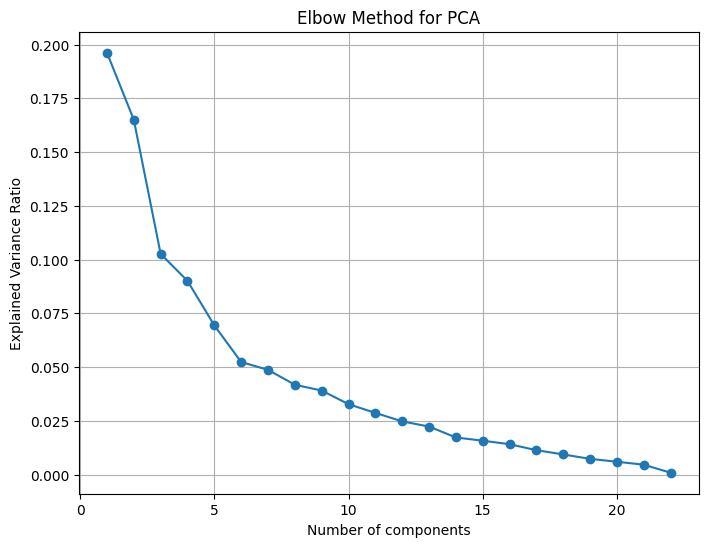

In [61]:
# Principle Component Analysis (PCA) for Categorical Data
def explained_variance(data, max_components=22):
    pca = PCA(n_components=max_components)
    pca.fit(data)
    return pca.explained_variance_ratio_
    
explained_variance_ratio = explained_variance(new)

plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance_ratio) +1), explained_variance_ratio, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Method for PCA')
plt.grid(True)
plt.show()

In [62]:
pca = PCA(n_components=5)
pca.fit(new)
new_data = pd.DataFrame(pca.transform(new), columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])
display(new_data)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3

,pc1,pc2,pc3,pc4,pc5
0,0.74,-0.02,0.36,-0.30,0.55
1,-0.66,0.85,0.24,-0.20,-0.42
2,-0.99,-0.41,0.33,-0.20,-0.04
3,0.58,-0.48,-0.11,0.54,-0.37
4,0.45,0.54,0.11,0.07,-0.25
...,...,...,...,...,...
3058,0.52,0.52,0.05,0.18,-0.20
3059,0.52,0.52,0.05,0.18,-0.20
3060,-0.68,0.92,0.27,-0.13,-0.54
3061,-0.60,-0.46,-0.40,0.09,-0.45


In [63]:
X_train = pd.DataFrame(X_train).join(new_data)
display(X_train)

,approval_index,runtime_category_Medium,runtime_category_Long,runtime_category_VeryLong,budget_scaled,year_scaled,pc1,pc2,pc3,pc4,pc5
0,5.48,1,0,0,-0.57,0.98,0.74,-0.02,0.36,-0.30,0.55
1,3.70,1,0,0,0.30,-0.21,-0.66,0.85,0.24,-0.20,-0.42
2,5.37,1,0,0,0.38,-0.73,-0.99,-0.41,0.33,-0.20,-0.04
3,4.02,1,0,0,-0.24,-1.62,0.58,-0.48,-0.11,0.54,-0.37
4,5.86,1,0,0,1.49,0.16,0.45,0.54,0.11,0.07,-0.25
...,...,...,...,...,...,...,...,...,...,...,...
3058,5.00,0,0,0,-0.57,-0.06,0.52,0.52,0.05,0.18,-0.20
3059,4.81,0,0,0,-0.12,-0.14,0.52,0.52,0.05,0.18,-0.20
3060,5.08,0,0,0,1.43,1.13,-0.68,0.92,0.27,-0.13,-0.54
3061,5.02,1,0,0,0.55,-0.73,-0.60,-0.46,-0.40,0.09,-0.45


### Feature Engineering - TEST SET

In [64]:
# Robust Scaling Budget
X_test[['budget_scaled']] = robust_scaler.transform(X_test[['budget']])
X_test.drop(columns=['budget'], inplace=True)

In [65]:
# Standard Scaling Year
X_test[['year_scaled']] = s_scaler.transform(X_test[['year']])
X_test.drop(columns=['year'], inplace=True)

In [66]:
# One-Hot Encoding Genre - TEST
new2 = X_test['genres'].str.get_dummies(sep=',')
display(new2)
del X_test['genres']

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,\N
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1310,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1311,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1312,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X


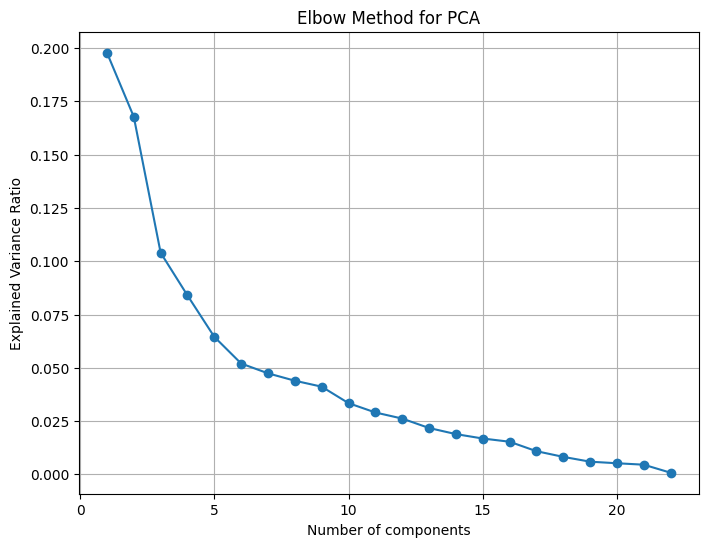

In [67]:
# Principle Component Analysis (PCA) for Categorical Data
def explained_variance(data, max_components=22):
    pca = PCA(n_components=max_components)
    pca.fit(data)
    return pca.explained_variance_ratio_
    
explained_variance_ratio = explained_variance(new2)

plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance_ratio) +1), explained_variance_ratio, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Method for PCA')
plt.grid(True)
plt.show()

In [68]:
new_data2 = pd.DataFrame(pca.transform(new2), columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])
display(new_data2)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


,pc1,pc2,pc3,pc4,pc5
0,0.69,-0.32,0.36,-0.11,-0.31
1,-0.32,-0.37,-0.82,-0.96,-0.05
2,0.08,-0.59,0.43,0.28,0.27
3,0.53,-0.27,0.35,-0.26,-0.24
4,-0.70,-0.55,-0.14,-0.19,0.40
...,...,...,...,...,...
1309,-0.16,0.75,-0.36,0.02,-0.10
1310,0.52,0.52,0.05,0.18,-0.20
1311,0.77,0.73,0.12,0.11,0.54
1312,-0.62,0.20,-0.51,1.10,0.09


In [69]:
X_test = pd.DataFrame(X_test).join(new_data2)
display(X_test)

,approval_index,runtime_category_Medium,runtime_category_Long,runtime_category_VeryLong,budget_scaled,year_scaled,pc1,pc2,pc3,pc4,pc5
0,6.31,1,0,0,0.68,1.28,0.69,-0.32,0.36,-0.11,-0.31
1,5.40,1,0,0,-0.20,0.68,-0.32,-0.37,-0.82,-0.96,-0.05
2,5.63,1,0,0,2.17,0.76,0.08,-0.59,0.43,0.28,0.27
3,6.11,1,0,0,0.55,0.24,0.53,-0.27,0.35,-0.26,-0.24
4,6.77,1,0,0,2.05,0.01,-0.70,-0.55,-0.14,-0.19,0.40
...,...,...,...,...,...,...,...,...,...,...,...
1309,2.53,1,0,0,1.68,0.98,-0.16,0.75,-0.36,0.02,-0.10
1310,5.24,1,0,0,-0.33,0.38,0.52,0.52,0.05,0.18,-0.20
1311,4.94,1,0,0,0.03,-0.29,0.77,0.73,0.12,0.11,0.54
1312,3.47,0,0,0,0.03,-0.21,-0.62,0.20,-0.51,1.10,0.09


### Extra Considerations

In [70]:
# Fix Data Types
X_train['approval_index'] = pd.to_numeric(X_train['approval_index'], errors='coerce')  
X_train['budget_scaled'] = pd.to_numeric(X_train['budget_scaled'], errors='coerce')
X_train['year_scaled'] = pd.to_numeric(X_train['year_scaled'], errors='coerce')
X_train['runtime_category_Medium'] = pd.to_numeric(X_train['runtime_category_Medium'], errors='coerce')
X_train['runtime_category_Long'] = pd.to_numeric(X_train['runtime_category_Long'], errors='coerce')
X_train['runtime_category_VeryLong'] = pd.to_numeric(X_train['runtime_category_VeryLong'], errors='coerce')

In [71]:
# Fix Data Types
X_test['approval_index'] = pd.to_numeric(X_test['approval_index'], errors='coerce') 
X_test['budget_scaled'] = pd.to_numeric(X_test['budget_scaled'], errors='coerce')
X_test['year_scaled'] = pd.to_numeric(X_test['year_scaled'], errors='coerce')
X_test['runtime_category_Medium'] = pd.to_numeric(X_test['runtime_category_Medium'], errors='coerce')
X_test['runtime_category_Long'] = pd.to_numeric(X_test['runtime_category_Long'], errors='coerce')
X_test['runtime_category_VeryLong'] = pd.to_numeric(X_test['runtime_category_VeryLong'], errors='coerce')

In [72]:
# Variance Inflation Factor (VIF)
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data
    
vif_df = calculate_vif(pd.DataFrame(X_train))
vif_df2 = calculate_vif(pd.DataFrame(X_test))
print(vif_df)
print(vif_df2)

                      feature  VIF
0              approval_index 7.13
1     runtime_category_Medium 6.60
2       runtime_category_Long 1.47
3   runtime_category_VeryLong 1.05
4               budget_scaled 1.87
5                 year_scaled 1.14
6                         pc1 1.35
7                         pc2 1.02
8                         pc3 1.12
9                         pc4 1.01
10                        pc5 1.02
                      feature  VIF
0              approval_index 6.96
1     runtime_category_Medium 6.36
2       runtime_category_Long 1.52
3   runtime_category_VeryLong 1.02
4               budget_scaled 1.86
5                 year_scaled 1.14
6                         pc1 1.39
7                         pc2 1.03
8                         pc3 1.15
9                         pc4 1.02
10                        pc5 1.02


In [73]:
# Double Check for Data Leakage
features = [
    'approval_index', 
    'budget_scaled', 
    'year_scaled', 
    'runtime_category_Medium', 
    'runtime_category_Long', 
    'runtime_category_VeryLong',
    'pc1',  
    'pc2', 
    'pc3', 
    'pc4', 
    'pc5', 
]
def detect_high_correlations(X, y, threshold=0.8):
    X = pd.DataFrame(X)  
    
    correlations = X.corrwith(y)
    high_corr_features = correlations[abs(correlations) > threshold].index.tolist()
    return high_corr_features, correlations

high_corr_features, correlations = detect_high_correlations(X_train, y_train, threshold=0.8)

print("\nFeature correlations with target:")
for feature in high_corr_features:
    correlation = correlations[feature]  
    print(f"{feature}: {correlation:.4f}")
if high_corr_features: 
    sns.scatterplot(x=pd.DataFrame(X_train)[high_corr_features[0]], y=y_train)
    plt.title(f'High Correlation Feature ({high_corr_features[0]}) vs Target')
    plt.show()
else:
    print("No features with high correlation detected.")


Feature correlations with target:
No features with high correlation detected.


# 5. Hyperparameter

In [75]:
# Trying all tree-based algorithms based on Default Parameters
GB = GradientBoostingRegressor(
    random_state=42,
)
CB = cb.CatBoostRegressor(
    random_state=42,
    silent=True,
)
XB = xgb.XGBRegressor(
    random_state=42,
    verbosity=0,
)
LB = lgb.LGBMRegressor(
    random_state=42
)
HIST = HistGradientBoostingRegressor(
    random_state=42
)
CART = DecisionTreeRegressor(
    random_state=42
)
RF = RandomForestRegressor(
    random_state=42
)

# Training all these models
GB.fit(X_train,y_train)
CB.fit(X_train,y_train)
XB.fit(X_train,y_train)
LB.fit(X_train,y_train)
HIST.fit(X_train,y_train)
CART.fit(X_train,y_train)
RF.fit(X_train,y_train)

r2_GB = r2_score(y_test, GB.predict(X_test))
r2_CB = r2_score(y_test, CB.predict(X_test))
r2_XB = r2_score(y_test, XB.predict(X_test))
r2_LB = r2_score(y_test, LB.predict(X_test))
r2_HIST = r2_score(y_test, HIST.predict(X_test))
r2_CART = r2_score(y_test, CART.predict(X_test))
r2_RF = r2_score(y_test, RF.predict(X_test))

print('GradientBoost:',r2_GB)
print('CatBoost:',r2_CB)
print('XGBoost:',r2_XB)
print('LightBoost:',r2_LB)
print('HistogramBoost:',r2_HIST)
print('CatAndRegTree:',r2_CART)
print('RandomForest:',r2_RF)

name = [
    'GradientBoost',
    'CatBoost',
    'XGBoost',
    'LightBoost',
    'HistogramBoost',
    'CatAndRegTree',
    'RandomForest']
accuracy = []
accuracy.append(r2_GB)
accuracy.append(r2_CB)
accuracy.append(r2_XB)
accuracy.append(r2_LB)
accuracy.append(r2_HIST)
accuracy.append(r2_CART)
accuracy.append(r2_RF)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 3063, number of used features: 10
[LightGBM] [Info] Start training from score 17.306953
GradientBoost: 0.6229698364517687
CatBoost: 0.6266066876705896
XGBoost: 0.5902018108509565
LightBoost: 0.612794488244759
HistogramBoost: 0.613783463728448
CatAndRegTree: 0.1788215024234202
RandomForest: 0.5875408003727548


In [ ]:
# Model Accuracies Bar Chart
data = pd.DataFrame({"Names": name, "Accuracies": accuracy})
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x="Accuracies", y="Names", data=data, color="lightcoral")
plt.xlim(0, 1)
plt.xlabel("Accuracy")
plt.ylabel("Model Names")
plt.title("Model Accuracies")
plt.show()

In [ ]:
# Feature Importances 
features = [
    'approval_index', 
    'budget_scaled', 
    'year_scaled', 
    'runtime_category_Medium', 
    'runtime_category_Long', 
    'runtime_category_VeryLong',
    'pc1',  
    'pc2', 
    'pc3', 
    'pc4', 
    'pc5', 
]
importances = CB.feature_importances_
feature_indexes_by_importance = importances.argsort()
for index in feature_indexes_by_importance:
    print("{} - {:.2f}%".format(features[index], (importances[index] * 100.0)))
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(
    range(len(feature_indexes_by_importance)), 
    importances[feature_indexes_by_importance], 
    align='center', 
    color='lightcoral' 
)
plt.yticks(range(len(feature_indexes_by_importance)), [features[i] for i in feature_indexes_by_importance])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Hyperparameter Tuning alongside K-Fold Cross Validation
start = time()
speed = {}

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 6, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 3.0),
        'border_count': trial.suggest_int('border_count', 200, 255),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'random_strength': trial.suggest_int('random_strength', 1.0, 3.0),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_maes = [] 
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model = cb.CatBoostRegressor(random_state=42, silent=True, **params)
        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), verbose=0)
        mae = mean_absolute_error(y_val_fold, model.predict(X_val_fold))
        fold_maes.append(mae)
    return np.mean(fold_maes)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best parameters:", best_params)

speed['CatBoosting'] = np.round(time()-start, 3)
print(f"Run time: {speed['CatBoosting']}s")

# 6. Train the Model

In [ ]:
model = cb.CatBoostRegressor(random_state=42, silent=True, **best_params)
model.fit(X_train, y_train)

# 7. Evaluate the Model

In [ ]:
# Statistical Analysis
mae_train = mean_absolute_error(y_train, model.predict(X_train))
mae_test = mean_absolute_error(y_test, model.predict(X_test))

r_squared = r2_score(y_test, model.predict(X_test))
mse = mean_squared_error(y_test, model.predict(X_test))
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

def adjusted_r_squared(y_true, y_pred, num_features):
    n = len(y_true)
    return 1 - ((1 - r_squared) * (n - 1) / (n - num_features - 1))

num_features = len(best_params)
adj_r_squared = adjusted_r_squared(y_test, model.predict(X_test), num_features)
train_adj_r_squared = adjusted_r_squared(y_train, model.predict(X_train), num_features)

print("MAE on training data:", mae_train)
print("MAE on testing data:", mae_test)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r_squared)
print("Adjusted R-squared:", adj_r_squared)
print("Adjusted R-squared FOR TRAIN:", train_adj_r_squared)

speed['CatBoost'] = np.round(time() - start, 3)
print(f"Run time: {speed['CatBoost']}s")